<div style="text-align: right"><i>Peter Norvig<br>April 2020</i></div>

# The Stable Matching Problem

The **[stable matching problem](https://en.wikipedia.org/wiki/Stable_marriage_problem#Algorithmic_solution)** involves two equally-sized disjoint sets of actors that want to pair off in a way that maximizes happiness. It could be a set of women and a set of men that want to pair off in heterosexual marriage; or a a set of job-seekers and a set of employers. Every year, there is a large-scale application of this problem in which:
- Graduating medical students state which hospitals they would prefer to be residents at.
- Hospitals in turn state which students they prefer. 
- An algorithm finds a stable matching.

Each actor has **preferences** for who they would like to be matched with. A matching is **stable** if it is **not** the case that there is an actor from one side and an actor from the other side who both have a higher preference for each other than they have for who they are currently matched with. 

In the default way of stating the problem, preferences are expressed as an **ordering**: each actor rates the possible matches on the other side from most preferred to least preferred. But in this notebook we will allow each actor to say more: to express their preference for each possible match as a **utility**: a number between 0 and 1. For example actor $A$ on one side could say that they would like to be paired with actor β on the other side with utility 0.9 (meaning a very desireable match) and with actor γ on the other side with utility 0.1 (meaning an undesireable match). The matching algorithm we present actually pays attention only to the ordering of preferences, but we will use the utilities to analyze how well each side does, on average.



# Gale-Shapley Matching Algorithm

The **[Gale-Shapley Stable Matching Algorithm](https://en.wikipedia.org/wiki/Gale%E2%80%93Shapley_algorithm)** (*Note: David Gale was my father's [PhD advisor](https://www.genealogy.math.ndsu.nodak.edu/id.php?id=4381).*) works as follows: one side is chosen to be the **proposers** and the other side the **acceptors**. Until everyone has been matched the algorithm repeats the following steps:
- An unmatched proposer, $p$, proposes a match to the highest-ranked acceptor, $a$, that $p$ has not yet proposed to.
- If $a$ is unmatched, then $a$ tentatively accepts the proposal to be a match.
- If $a$ is matched, but prefers $p$ to their previous match, then $a$ breaks the previous match and tentatively accepts $p$.
- If $a$ is matched and prefers their previous match to $p$, then $a$ rejects the proposal.

I will define the function `stable_matching(P, A)`, which is passed two preference arrays: $N \times N$ arrays of utility values such that `P[p][a]` is the utility that proposer `p` has for being matched with  `a`, and `A[a][p]` is the utility that acceptor `a` has for being matched with `p`. The function returns a set of matches, `{(p, a), ...}`. To implement the algorithm sketched above, we keep track of the following variables:
- `ids`: If there are $N$ actors on each side, we number them $0$ to $N-1$; `ids` is the collection of these numbers.
- `unmatched`: the set of proposers that have not yet been matched to any acceptor.
- `matched`: A mapping from acceptors to their matched proposers: `matched[a] = p`.
- `proposals`: Keeps track of who each proposer should propose to next. `proposals[p]` is a list of acceptors sorted by increasing utility, which means that `proposals[p].pop()` returns (and removes) the best acceptor for $p$ to propose to next. 

In [1]:
import matplotlib.pyplot as plt
from statistics import mean, stdev
from typing import *
import random

# Types
ID = int # ID number for an actor
Utility = float # Real number form 0 to 1 indicating degree of preference
Match = Tuple[ID, ID] # A pair of actors who are matched
PrefArray = List[List[Utility]] # Preference of each actor on a side for each actor on other side

def stable_matching(P: PrefArray, A: PrefArray) -> Set[Match]:
    """Compute a stable match, a set of (p, a) pairs.
    P and A are square preference arrays: P[p][a] is how much p likes a;
    A[a][p] is how much a likes p. Stable means there is no (p, a)
    such that both prefer each other over the partner they are matched with."""
    ids = range(len(P))           # ID numbers of all actors on either side
    unmatched = set(ids)          # Members of P that are not yet matched to anyone
    matched = {}                  # {a: p} mapping of who acceptors are matched with
    proposals = [sorted(ids, key=lambda a: P[p][a]) 
                 for p in ids]    # proposals[p] is an ordered list of who p should propose to
    while unmatched:
        p = unmatched.pop()       # p is an arbitrary unmatched Proposer
        a = proposals[p].pop()    # a is p's most preferred remaining acceptor
        if a not in matched:      # first proposal to a; a tentatively accepts
            matched[a] = p
        elif A[a][p] > A[a][matched[a]]: # a breaks previous engagement and accepts
            unmatched.add(matched[a])
            matched[a] = p
        else:
            unmatched.add(p)      # proposal declined; p remains unmatched
    return {(p, a) for (a, p) in matched.items()}

The algorithm has the following properties:
- The algorithm will always terminate.
- The output of the algorithm will always be a stable matching.
- Out of all possible stable matchings, it will produce the one that is optimal for proposers: each proposer gets the best possible match they could get. That's true because the proposers propose in order of preference, so the acceptor that they most prefer who also prefers them will accept their proposal.
- The acceptors have no such luck; they might not get their best possible match, because a proposer who is a better match for them might not ever propose to them.

What I want to get a handle on is: *how bad is this for the acceptors?* What's the gap in expected utility between the proposers and the acceptors?

# Preference Arrays

Let's define some preference arrays. `I` is the identity matrix: it says that every proposer number $i$ likes acceptor $i$ best, and dislikes the others equally. 

In [2]:
I = [[1, 0, 0, 0, 0],
     [0, 1, 0, 0, 0],
     [0, 0, 1, 0, 0],
     [0, 0, 0, 1, 0],
     [0, 0, 0, 0, 1]]

If both sides have this same preference array, it should result in a stable matching of (*i*, *i*) pairs:

In [3]:
stable_matching(I, I)

{(0, 0), (1, 1), (2, 2), (3, 3), (4, 4)}

We can measure the average utility for both sides:

In [4]:
def mean_utilities(P, A):
    """The mean utility over all members of P, and the mean utility over all members of A,
    for the matching given by stable_matching(P, A)."""
    matching = stable_matching(P, A)
    return (mean(P[p][a] for (p, a) in matching),
            mean(A[a][p] for (p, a) in matching))

In [5]:
mean_utilities(I, I)

(1, 1)

Perfect! Both sides achieve the maximum utility, 1.

Next, preference array `X` is almost the same as the identity matrix, except that proposer 3 prefers 4, not 3, and proposer 4 prefers 3, not 4.

In [6]:
X = [[1, 0, 0, 0, 0],
     [0, 1, 0, 0, 0],
     [0, 0, 1, 0, 0],
     [0, 0, 0, 0, 1],
     [0, 0, 0, 1, 0]]

We see that the way that 3 and 4 get matched depends on which side is the proposer:

In [7]:
stable_matching(I, X)

{(0, 0), (1, 1), (2, 2), (3, 3), (4, 4)}

In [8]:
stable_matching(X, I)

{(0, 0), (1, 1), (2, 2), (3, 4), (4, 3)}

The proposers always do better (or no worse than) the acceptors in mean utility:

In [9]:
mean_utilities(I, X)

(1, 0.6)

In [10]:
mean_utilities(X, I)

(1, 0.6)

Similar results hold when we use preference arrays that have utilities that are spread out between 0 and 1; it is still better to be the proposing side:

In [11]:
A = [[.9, .4, .3, .2, .1],
     [.1, .9, .4, .3, .2],
     [.2, .1, .9, .4, .3],
     [.3, .2, .1, .9, .4],
     [.4, .3, .2, .1, .9]]

B = [[.9, .4, .3, .2, .1],
     [.1, .9, .4, .3, .2],
     [.2, .1, .9, .4, .3],
     [.1, .2, .3, .4, .9],
     [.9, .4, .3, .2, .1]]

In [12]:
stable_matching(A, B)

{(0, 0), (1, 1), (2, 2), (3, 3), (4, 4)}

In [13]:
mean_utilities(A, B)

(0.9, 0.64)

In [14]:
stable_matching(B, A)

{(0, 0), (1, 1), (2, 2), (3, 4), (4, 3)}

In [15]:
mean_utilities(B, A)

(0.76, 0.64)

# Preferences with Common and Private Values

If the Gale-Shapley algorithm is used in high-stakes applications like matching medical residents to hospitals, does it make a big difference which side is the proposers? In the toy examples above, it does make a difference; in some cases the acceptors got only 60% of their possible utility, while the proposers got up to 100%. 

I will address the question by examining some randomized preference arrays and getting a feeling for how they perform. But I don't want them to be completely random; I want them to reflect, in a very abstract way, some properties of the real world:
- Some choices have intrinsic properties that make them widely popular (or unpopular). For example, Massachusetts General Hospital is considered an excellent choice by many aspiring residents. The amount of utility that is commonly agreed upon is called the **common value** of a choice.
- Some choices have idiosyncratic properties that appeal only to specific actors. For example, you might really want to be a resident at your hometown hospital, even if it is not highly-regarded by others. This is the **private value** of a choice.
- In real world situations there is usually a mix of common and private value.

The function call `preferences(N, 0.75)`, for example, creates an NxN array of preferences, where each preference is 75% common value and 25% individual value. I implement individual value as being proportional to the ID number (`a` in the code); that is equivalent to assuming  that the hospitals (say) are sorted in increasing order of quality by ID number.

In [16]:
def preferences(N=25, c=0.75):
    """Create an NxN preference array, weighted: c × common + (1 - c) × random."""
    return [[round(c * (a + 0.5) / N + (1 - c) * random.uniform(0, 1), 3)
            for a in range(N)] 
            for p in range(N)]

random.seed(99) # For reproducability

Below is a 7x7 preference array that is half common, half private. You can see as you go across a row that the utilities tend to increase, but not always monotonically:

In [17]:
preferences(7, 0.5)

[[0.238, 0.207, 0.268, 0.374, 0.701, 0.518, 0.656],
 [0.378, 0.376, 0.648, 0.495, 0.532, 0.699, 0.573],
 [0.487, 0.294, 0.373, 0.591, 0.398, 0.723, 0.889],
 [0.205, 0.581, 0.443, 0.637, 0.556, 0.594, 0.599],
 [0.04, 0.209, 0.673, 0.517, 0.552, 0.843, 0.767],
 [0.524, 0.286, 0.286, 0.71, 0.402, 0.789, 0.762],
 [0.527, 0.579, 0.509, 0.269, 0.333, 0.63, 0.874]]

Here's a preference array with no common value; the utilities are completely random, uncorrelated to their position:

In [18]:
preferences(7, 0.0)

[[0.081, 0.425, 0.086, 0.31, 0.006, 0.33, 0.523],
 [0.201, 0.787, 0.055, 0.211, 0.258, 0.404, 0.764],
 [0.354, 0.695, 0.922, 0.131, 0.864, 0.6, 0.747],
 [0.608, 0.408, 0.096, 0.144, 0.174, 0.178, 0.146],
 [0.208, 0.561, 0.771, 0.798, 0.846, 0.117, 0.822],
 [0.186, 0.072, 0.288, 0.586, 0.048, 0.216, 0.399],
 [0.822, 0.399, 0.414, 0.371, 0.093, 0.88, 0.923]]

And here's a preference array with 100% common value: every row is identical, and the utilities monotonically increase across the row:

In [19]:
preferences(5, 1.0)

[[0.1, 0.3, 0.5, 0.7, 0.9],
 [0.1, 0.3, 0.5, 0.7, 0.9],
 [0.1, 0.3, 0.5, 0.7, 0.9],
 [0.1, 0.3, 0.5, 0.7, 0.9],
 [0.1, 0.3, 0.5, 0.7, 0.9]]

The `preferences` function has been designed so that the average utility value is close to 0.5, for all values of `c`:

In [20]:
mean(map(mean, preferences(100, c=0.8)))

0.4996304

In [21]:
mean(map(mean, preferences(100, c=0.2)))

0.5004173

Now for one more helpful function: `examples` returns a list of the form `[(P, A), ...]` where `P` and `A` are preference arrays.

In [22]:
def examples(N=25, c=0.5, repeat=10000):
    """A list of pairs of preference arrays, (P, A), of length `repeat`."""
    return [(preferences(N, c), preferences(N, c)) for _ in range(repeat)]

In [23]:
examples(N=3, repeat=2)

[([[0.181, 0.736, 0.7], [0.207, 0.734, 0.599], [0.572, 0.745, 0.715]],
  [[0.537, 0.72, 0.784], [0.281, 0.256, 0.582], [0.452, 0.657, 0.554]]),
 ([[0.464, 0.575, 0.662], [0.23, 0.416, 0.821], [0.342, 0.381, 0.658]],
  [[0.471, 0.517, 0.603], [0.201, 0.365, 0.482], [0.102, 0.347, 0.479]])]

# Histograms of Acceptor/Proposer Utility

Now we're ready to answer the original question: how much worse is it to be an acceptor rather than a proposer? The function `show` displays two overlapping histograms of mean utilities: one for acceptors and one for proposers. 

In [24]:
def show(N=25, c=0.5, repeat=10000, bins=50):
    """Show two histograms of mean utility values over examples, for proposers and acceptors."""
    pr, ac = transpose(mean_utilities(P, A) for (P, A) in examples(N, c, repeat))
    plt.hist(pr, bins=bins, alpha=0.5)
    plt.hist(ac, bins=bins, alpha=0.5);
    print(f'''{repeat:,d} examples with N = {N} actors, common value ratio c = {c}
    Acceptors: {mean(ac):.3f} ± {stdev(ac):.3f}
    Proposers: {mean(pr):.3f} ± {stdev(pr):.3f}''')
    
def transpose(matrix): return list(zip(*matrix))

We'll start with preferences that are completely private; no common value:

10,000 examples with N = 25 actors, common value ratio c = 0.0
    Acceptors: 0.729 ± 0.063
    Proposers: 0.871 ± 0.035


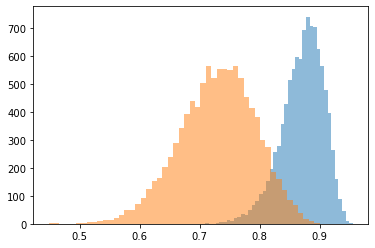

In [25]:
show(c=0.0)

The acceptors (the orange histogram) have a mean utility of 0.730 while the proposers (blue histogram) do much better with a mean of 0.870. Both sides do much better than the 0.5 average utility that they would average if we just used a random (non-stable) matching. 

It is clear that proposers do much better than acceptors. That suggests that the `stable_matching` algorithm is very unfair. But before drawing that conclusion, let's consider preferences with a 50/50 mix of private/common value. We'll do that for two different population sizes, 25 and 50:

10,000 examples with N = 25 actors, common value ratio c = 0.5
    Acceptors: 0.621 ± 0.021
    Proposers: 0.638 ± 0.019


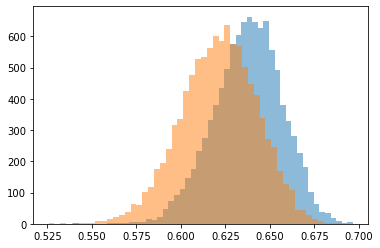

In [26]:
show(c=0.5, N=25)

10,000 examples with N = 50 actors, common value ratio c = 0.5
    Acceptors: 0.647 ± 0.013
    Proposers: 0.661 ± 0.012


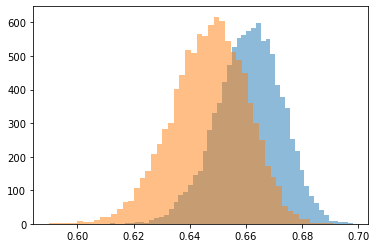

In [27]:
show(c=0.5, N=50)

We see that the gap between proposer and acceptor has been greatly reduced (but not eliminated). With more actors, the variance is smaller (the histogram is not as wide). 

What happens with 90% common value? How aboout 99%?

10,000 examples with N = 25 actors, common value ratio c = 0.9
    Acceptors: 0.509 ± 0.005
    Proposers: 0.510 ± 0.005


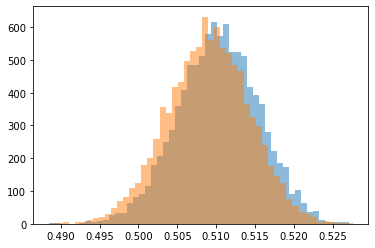

In [28]:
show(c=0.9)

10,000 examples with N = 25 actors, common value ratio c = 0.99
    Acceptors: 0.500 ± 0.001
    Proposers: 0.500 ± 0.001


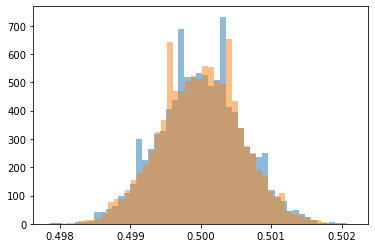

In [29]:
show(c=0.99)

We see that there is very little difference between the two sides. So the conclusion is: when there is a lot of common value, the Gale-Shapley Matching Algorithm is almost fair: the proposers have an advantage, but it is minimal. So it is probably okay to use the algorithm for matching medical residents, because there is a lot of common value in the perception of the quality of hospitals, and likewise for the quality of students.

But when there is mostly private value, the algorithm is unfair, favoring the proposers over the acceptors.